<a href="https://colab.research.google.com/github/choinkeol/PyTorch_firststep/blob/master/lanscape_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

codes are borrowed from https://github.com/cailk/ensemble-adv-training-pytorch

In [ ]:
import torch
import torchvision
import torch.optim as optim
import torch.utils.data
from torchvision import datasets, transforms
import argparse
import os
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import os
import glob
import imageio
import natsort


In [ ]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 5)
        self.conv2 = nn.Conv2d(64, 64, 5)
        #self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 20 * 20, 128)
        #self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        #x = self.dropout1(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        #x = self.dropout2(x)
        x = self.fc2(x)
        return x

def load_model(model_path, type=1):
    model = Net()
    model.load_state_dict(torch.load(model_path+'.pkl'))
    return model

In [ ]:
EVAL_FREQUENCY = 100
SAVE_FREQUENCY=50

def train(epoch, batch_idx, model, data, labels, optimizer, k ,x_advs=None):
    model.train()
    optimizer.zero_grad()
    # Generate cross-entropy loss for training
    logits = model(data)
    loss = F.cross_entropy(logits, labels, reduction='mean')
    loss.backward()
    optimizer.step()
    if batch_idx % EVAL_FREQUENCY == 0:
        preds = logits.max(1)[1]
        print('Step: {}(epoch: {})\tLoss: {:.6f}\tError: {:.2f}%'.format(
            batch_idx, epoch+1, loss.item(), error_rate(preds, labels)
        ))
    if batch_idx % SAVE_FREQUENCY==0:
      torch.save(model.state_dict(),"model"+str(k)+".pkl")
      print('Step: {}(epoch: {}) model{}'.format(
            batch_idx, epoch+1,k))

def test(model, data, labels):
    model.eval()
    correct = 0
    logits = model(data)

    # Prediction for the test set
    preds = logits.max(1)[1]
    correct += preds.eq(labels).sum().item()
    return correct

def error_rate(preds, labels):
    '''
    Run the error rate
    '''
    assert preds.size() == labels.size()
    return 100.0 - (100.0 * preds.eq(labels).sum().item()) / preds.size(0)


In [ ]:
seed = 1

def main():
    k=1
    torch.manual_seed(seed)
    device = torch.device('cuda' if cuda else 'cpu')

    '''
    Preprocess MNIST dataset
    '''
    kwargs = {'num_workers': 20, 'pin_memory': True} if cuda else {}
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../attack_mnist', train=True, download=True, transform=transforms.ToTensor()),
        batch_size=batch_size, shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../attack_mnist', train=False, transform=transforms.ToTensor()),
        batch_size=batch_size, shuffle=False, **kwargs)

    model = Net().to(device)
    optimizer = optim.Adam(model.parameters())
    torch.save(model.state_dict(), 'model0.pkl')

    # Train an MNIST model
    for epoch in range(epochs):
        for batch_idx, (data, labels) in enumerate(train_loader):
            data, labels = data.to(device), labels.to(device)
            train(epoch, batch_idx, model, data, labels, optimizer, k)
            if batch_idx % SAVE_FREQUENCY==0:
              k=k+1

    # Finally print the result!
    correct = 0
    with torch.no_grad():
        for (data, labels) in test_loader:
            data, labels = data.to(device), labels.to(device)
            correct += test(model, data, labels)
    test_error = 100. - 100. * correct / len(test_loader.dataset)
    print('Test Set Error Rate: {:.2f}%'.format(test_error))

    torch.save(model.state_dict(), 'mnist.pkl')
    return model



In [ ]:
#parser = argparse.ArgumentParser(description='Training MNIST model')
#parser.add_argument('model', help='path to model')
#parser.add_argument('--seed', type=int, default=1, help='Random seed (default: 1)')
#parser.add_argument('--disable_cuda', action='store_true', default=False, help='Disable CUDA (default: False)')
#parser.add_argument('--batch_size', type=int, default=64, help='Size of training batches (default: 64)')
#parser.add_argument('--epochs', type=int, default=6, help='Number of epochs to train (default: 6)')
#parser.print_help()
#args = parser.parse_args()

batch_size = 64
epochs = 6
cuda = torch.cuda.is_available()
model = main()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../attack_mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../attack_mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../attack_mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../attack_mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../attack_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../attack_mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../attack_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../attack_mnist/MNIST/raw



/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Step: 0(epoch: 1)	Loss: 2.305706	Error: 93.75%
Step: 0(epoch: 1) model1
Step: 50(epoch: 1) model2
Step: 100(epoch: 1)	Loss: 0.256858	Error: 6.25%
Step: 100(epoch: 1) model3
Step: 150(epoch: 1) model4
Step: 200(epoch: 1)	Loss: 0.104344	Error: 1.56%
Step: 200(epoch: 1) model5
Step: 250(epoch: 1) model6
Step: 300(epoch: 1)	Loss: 0.104942	Error: 3.12%
Step: 300(epoch: 1) model7
Step: 350(epoch: 1) model8
Step: 400(epoch: 1)	Loss: 0.037132	Error: 1.56%
Step: 400(epoch: 1) model9
Step: 450(epoch: 1) model10
Step: 500(epoch: 1)	Loss: 0.117709	Error: 3.12%
Step: 500(epoch: 1) model11
Step: 550(epoch: 1) model12
Step: 600(epoch: 1)	Loss: 0.072753	Error: 1.56%
Step: 600(epoch: 1) model13
Step: 650(epoch: 1) model14
Step: 700(epoch: 1)	Loss: 0.060807	Error: 1.56%
Step: 700(epoch: 1) model15
Step: 750(epoch: 1) model16
Step: 800(epoch: 1)	Loss: 0.172196	Error: 4.69%
Step: 800(epoch: 1) model17
Step: 850(epoch: 1) model18
Step: 900(epoch: 1)	Loss: 0.079549	Error: 3.12%
Step: 900(epoch: 1) model19
S

In [ ]:
import torch

def gen_grad(model, x, y):
    '''
    Generate the gradient of the loss function.
    '''
    model.eval()
    x.requires_grad = True

    # Define gradient of loss wrt input
    logits = model(x)
    loss = F.cross_entropy(logits, y, reduction='mean')
    model.zero_grad()
    loss.backward()
    grad = x.grad.data
    return grad

def fgsm(x, grad, eps=0.003, clipping=True):
    '''
    FGSM attack.
    '''
    # Add perturbation to original example to obtain adversarial example
    adv_x = x.detach() + eps * grad.detach().sign()
    adv_x = torch.clamp(adv_x, 0, 1)
    return adv_x

def pgd(model, x, y, steps, eps):
    '''
    I-FGSM attack.
    '''
    adv_x = x

    # iteratively apply the FGSM with small step size
    for i in range(steps):
        grad = gen_grad(model, adv_x, y)
        adv_x = fgsm(adv_x, grad, eps)
    return adv_x

In [ ]:


def get_x_adv_x(steps=10, eps=0.003):
    torch.manual_seed(seed)
    device = torch.device('cuda' if cuda else 'cpu')

    '''
    Preprocess MNIST dataset
    '''
    kwargs = {'num_workers': 20, 'pin_memory': True} if cuda else {}
    tr_dl = torch.utils.data.DataLoader(
        datasets.MNIST('../attack_mnist', train=True, transform=transforms.ToTensor()),
        batch_size=batch_size, shuffle=False, **kwargs)
   
    correct = 0
    for (x, y) in tr_dl:
        x, y = x.to(device), y.to(device)
        grad = gen_grad(model, x, y)
        adv_x = pgd(model, x, y, steps=steps, eps=eps)
        break
    x=x.to(device).detach()
    x=torch.permute(x,(1,0,2,3))
    x=x.squeeze()
    x_0=x[0,:,:]
    adv_x=adv_x.detach()
    adv_y=model(adv_x).max(dim=1)[1]
    adv_x=torch.permute(adv_x,(1,0,2,3))
    adv_x=adv_x.squeeze()
    adv_x=adv_x[0,:,:]
    return x, x_0, adv_x, y, adv_y

In [ ]:
attack = None

x, x_0, adv_x, y, adv_y = get_x_adv_x()
x_0=torch.reshape(x_0,(1,784))
adv_x=torch.reshape(adv_x,(1,784))

In [ ]:
print(x.shape, x_0.shape, adv_x.shape)

torch.Size([64, 28, 28]) torch.Size([1, 784]) torch.Size([1, 784])


In [ ]:
v1=(adv_x-x_0).detach()
print(v1.shape)

torch.Size([1, 784])


In [ ]:
def get_eig_of(x):
  x=torch.reshape(x,(64,784))
  x_mean = x.mean(dim=0)
  x = x-x_mean.unsqueeze(0)
  x_t=x.transpose(0,1)
  xcv=torch.matmul(x_t,x)
  sigma = 1/(64-1) * xcv 
  return torch.linalg.eig(sigma)


In [ ]:
def get_largest_eig_vec(x):
  w, v = get_eig_of(x)
  w=w.unsqueeze(0)
  w=w.float()
  i_w_max=w.argmax()
  v2=v[:,i_w_max].unsqueeze(0).cuda().float()
  return v2, w, v

In [ ]:
v2, w, v = get_largest_eig_vec(x)

<ipython-input-12-2cbc75752282>:4: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:250.)
  w=w.float()


In [ ]:
v1 = v1/torch.norm(v1, dim=-1, p=2)
v2 = v2/torch.norm(v2, dim=-1, p=2)
print((v1*v2).sum(-1))

tensor([0.0220], device='cuda:0')


In [ ]:
def get_orth_v_to_u(u, v):
  proj=(u*v).sum(-1)/(u*u).sum(-1)*v 
  v=v-proj
  v = v/torch.norm(v, dim=-1, p=2)
  return v

In [ ]:
v2 = get_orth_v_to_u(v1, v2)

In [ ]:
def get_grid_x(v1, v2):
  e = torch.linspace(-0.003, 0.003, steps=100).cuda()
  v1s = torch.outer(e, v1.squeeze())
  v2s = torch.outer(e, v2.squeeze())
  v1_new = v1s.transpose(0,1).unsqueeze(1)
  v2_new = v2s.transpose(0,1).unsqueeze(2)
  grid = v1_new + v2_new
  grid = grid.permute(1, 2, 0)
  grid = grid.reshape(-1, 784)
  grid_x = grid + x_0
  grid_x = grid_x.reshape(-1,1,28,28)
  return grid_x.cuda().float()

In [ ]:
grid_x = get_grid_x(v1, v2)

In [ ]:
#torch.cuda.empty_cache()
#device=torch.device('cuda' if cuda else 'cpu')
#grid_x=grid_x.to(device).float()
#import torch, gc
#gc.collect()
#torch.cuda.empty_cache()

In [ ]:
def plot(idx, grid_x, y, adv_y):
  xs=torch.linspace(-0.003,0.003,steps=100)
  ys=torch.linspace(-0.003,0.003,steps=100)
  xx,yy=torch.meshgrid(xs,ys,indexing='ij')
  xx=xx.numpy()
  yy=yy.numpy()
  model=load_model("model"+str(idx)).cuda()
  grid_fx = model(grid_x).reshape(100,100,10)
  grid_y = grid_fx[:,:,y]
  grid_adv_y = grid_fx[:,:,adv_y]
  grid_diff_y_adv_y = grid_y - grid_adv_y
  fig, axs = plt.subplots(1,3,figsize=(4, 4.3*3), subplot_kw={'aspect':'equal'})
  #fig = plt.figure()
  #ax = fig.add_subplot(111, projection='3d')
  z_lst = [grid_y, grid_adv_y, grid_diff_y_adv_y]
  for i in range(3):
    ax = axs[i]
    #ax.view_init(0,0)
    #ax.set_zlim(-1,1)   
    zz = z_lst[i].cpu().detach().numpy()
    ax.pcolormesh(xx, zz, cmap=plt.cm.jet)
    fig.tight_layout()
  plt.savefig("plot_model"+str(idx))

TypeError: ignored

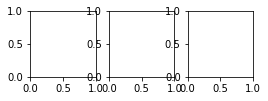

In [ ]:

for i in range(0,6):
  plot(19*i, grid_x, y, adv_y)

filename=glob.glob("plot*")
filenames=natsort.natsorted(filename)
images = [imageio.imread(filename) for filename in filenames]
path = 'gif.gif'
imageio.mimsave(path, images, duration=0.5)
os.system('gifsicle —scale 0.7 -O3 {} -o {} '.format(path, path))